In [73]:
import pandas as pd
import numpy as np
import gensim
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
import logging
import multiprocessing
import os
from collections import namedtuple

FORMAT = '%(asctime)s %(levelname)s %(message)s'
DATEFORMAT = '%Y-%m-%d %H:%M:%S'
logging.basicConfig(level=logging.WARNING,
                    format=FORMAT,
                    datefmt=DATEFORMAT)
logger = logging.getLogger(__name__)

In [74]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
models_dir = os.path.join(parent_dir, 'models')
print('working directory: ', os.getcwd())
print('data directory:    ', data_dir, )
print('models directory:  ', models_dir)

working directory:  C:\Users\Joni\Dropbox (Privat)\CODE\InformationSystemsWS1718\notebooks
data directory:     C:\Users\Joni\Dropbox (Privat)\CODE\InformationSystemsWS1718\data
models directory:   C:\Users\Joni\Dropbox (Privat)\CODE\InformationSystemsWS1718\models


In [126]:
data = pd.read_pickle(os.path.join(data_dir, 'data_clean_4cols.pickle'))
data

,id,from_name,message,Partei_ABK
0,1586699104972808_1625886087720776,Valentin Abel,Gerade einmal 9.000 Anträge auf die Kaufprämie...,FDP
1,1586699104972808_1626084567700928,Valentin Abel,"""Die Liberalen stehen für einen individualisti...",FDP
2,1586699104972808_1627233684252683,Valentin Abel,Wir sind bereit für 2017 - machen wir Deutschl...,FDP
3,1586699104972808_1627428260899892,Valentin Abel,Kann ein Jahr besser beginnen als mit einem gu...,FDP
4,1586699104972808_1628833480759370,Valentin Abel,Platz 12 im diesjährigen #Landkreis-Ranking vo...,FDP
5,1586699104972808_1629446607364724,Valentin Abel,"In Zeiten, in denen die Welt aus den Fugen zu ...",FDP
6,1586699104972808_1629559267353458,Valentin Abel,"Fällt euch spontan etwas ein, auf das sich 83%...",FDP
7,1586699104972808_1630578820584836,Valentin Abel,"Die #AfD missbraucht Sophie #Scholl, Widerstan...",FDP
8,1586699104972808_1632129530429765,Valentin Abel,Die #Legalisierung von #Cannabis kann nur ein ...,FDP
9,1586699104972808_1636145450028173,Valentin Abel,Bereit für 2017 – anders lässt sich die Stimmu...,FDP


In [79]:
candidate_data = (data.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
#                      .set_index('from_name')
                 )
candidate_data.tail(10)

,from_name,Partei_ABK
173042,Dr. Daniela De Ridder,SPD
173559,Björn Simon,CDU
173902,Waldemar Westermayer,CDU
173963,AfD Party,AfD
174481,CDU Party,CDU
174974,SPD Party,SPD
175488,CSU Party,CSU
176078,GRÜNE Party,GRÜNE
176425,FDP Party,FDP
176969,DIE LINKE Party,DIE LINKE


In [82]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('german'))
MessageDoc = namedtuple('MessageDoc', 'words tags split')
alldocs = []  # Will hold all docs in original order
for line_no, line in data.iterrows():
    #import pdb; pdb.set_trace()
    message = line.message.lower()
    words = tokenizer.tokenize(message)
    tags = [str(line_no), line['from_name'], line['Partei_ABK']] # line_no needs to be converted as string to be included in tags 
    split = ['train', 'test', 'extra', 'extra'][line_no//200000]  # 25k train, 25k test, 25k extra
    alldocs.append(MessageDoc(words, tags, split))

In [83]:
tags

['177306', 'DIE LINKE Party', 'DIE LINKE']

In [84]:
len(alldocs)

177307

In [85]:
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

In [86]:
model = gensim.models.Doc2Vec(dm=0, size=100, min_count=5)
model.build_vocab(alldocs)
model.train(alldocs, total_examples=model.corpus_count, epochs=2, start_alpha=0.025, end_alpha=0.001)

14316396

In [10]:
# saving the model doesn't work. Why?
#model.save(os.path.join(models_dir, 'doc2vec_c.model'))
#logger.info('model saved')

In [87]:
word_vecs = model.wv
doc_vecs = model.docvecs

In [88]:
#doc_vecs.doctags['FDP']
#word_vecs.vocab

Doctag(offset=2, word_count=801059, doc_count=21837)

In [89]:
# calculate similarity for all candidates and parties
for party in ['SPD Party', 'CDU Party', 'DIE LINKE Party', 'AfD Party', 'CSU Party', 'GRÜNE Party', 'FDP Party']:
    candidate_data[party] = candidate_data['from_name'].map(lambda candidate: model.docvecs.similarity(candidate, party))
    
# make a new columns holding which party is most similar
candidate_data['most similar'] = candidate_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate_data.head()

,from_name,Partei_ABK,SPD Party,CDU Party,DIE LINKE Party,AfD Party,CSU Party,GRÜNE Party,FDP Party,most similar
0,Valentin Abel,FDP,0.407435,0.343481,0.327065,0.218631,0.377207,0.493898,0.822449,FDP Party
93,Dr. Michael von Abercron,CDU,0.480900,0.759679,0.431211,0.237089,0.413825,0.452556,0.446051,CDU Party
168,Grigorios Aggelidis,FDP,0.395318,0.404782,0.399016,0.303823,0.348450,0.427632,0.544077,FDP Party
215,Diyar Agu,DIE LINKE,0.446537,0.468411,0.794946,0.220243,0.179546,0.395915,0.449028,DIE LINKE Party
269,Gökay Akbulut DIE LINKE,DIE LINKE,0.509760,0.453532,0.696222,0.281292,0.450785,0.595965,0.451068,DIE LINKE Party


In [107]:
candidate_data.shape

(1008, 10)

In [90]:
most_similar_candidates = pd.crosstab(candidate_data['Partei_ABK'], candidate_data['most similar'])

In [91]:
most_similar_candidates

most similar,AfD Party,CDU Party,CSU Party,DIE LINKE Party,FDP Party,GRÜNE Party,SPD Party
Partei_ABK,,,,,,,
AfD,121,0,1,1,0,1,0
CDU,4,186,3,4,0,8,4
CSU,0,0,46,0,0,0,0
DIE LINKE,2,0,0,109,0,0,0
FDP,2,0,1,1,165,2,2
GRÜNE,1,0,0,2,0,91,1
SPD,0,1,16,12,1,7,213


In [19]:
#sums = pd.crosstab(candidate_data['Partei_ABK'], candidate_data['most similar'])

In [115]:
model.docvecs.count

178322

In [104]:
# filter out the candidate data
mask = [tag in candidate_data['from_name'].values for tag in model.docvecs.offset2doctag]
candidate_vecs = model.docvecs.doctag_syn0[mask]

In [106]:
len(candidate_vecs)

1008

In [108]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

[Colors in Matplotlib](https://matplotlib.org/api/colors_api.html)

[Color names from xkcd](https://xkcd.com/color/rgb/)

In [120]:
party_colors = {'AfD': 'xkcd:blue',
                'DIE LINKE': 'xkcd:magenta',
                'GRÜNE': 'xkcd:grass green',
                'CSU': 'xkcd:sky blue',
                'CDU': 'xkcd:black',
                'FDP': 'xkcd:goldenrod',
                'SPD': 'xkcd:red'}
candidate_data['color'] = candidate_data['Partei_ABK'].map(party_colors)

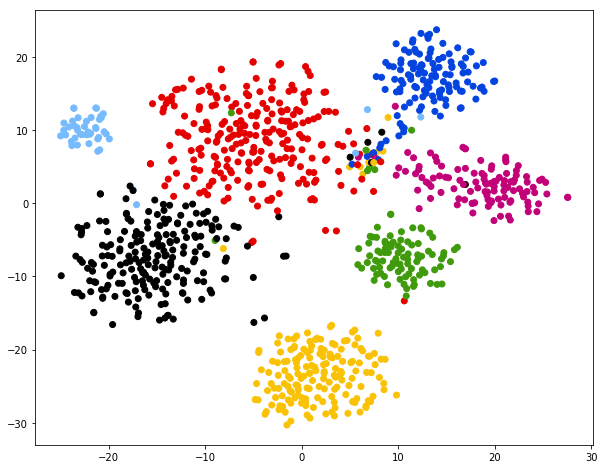

In [125]:
plt.figure(num=None, figsize=(10, 8))  # set the figure size
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=candidate_data['color'])
plt.show()